<a href="https://colab.research.google.com/github/AlexanderVieira/training_datascience/blob/main/DR4_AT_AlexanderSilva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install pmdarima

In [40]:
!pip install yellowbrick

In [41]:
!pip install sweetviz

In [42]:
import math
import datetime
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
import matplotlib.dates as mdates
from scipy import stats
from scipy.stats import expon
from scipy.stats import poisson
from pmdarima import model_selection
from pmdarima.arima import auto_arima
from pmdarima.arima.stationarity import ADFTest
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from yellowbrick.classifier import ConfusionMatrix
import sweetviz as sv
from IPython.display import Image

##**1. Assista ao vídeo: https://www.youtube.com/watch?v=IlseDXUwFZQ. Depois baixe os dados (https://drive.google.com/ file/d/1SDh9JGCzJ2YiDkZf60Rcm3Xf4xnUjA24/view?usp=sharing) sobre os arremessos do Kobe Bryant e criar um dataframe de pandas**

In [43]:
dataset = pd.read_csv('/content/kobe_bryant_shots_data.csv')
dataset.head()

action_type combined_shot_type  game_event_id   game_id      lat  \
0          Jump Shot          Jump Shot             10  20000012  33.9723   
1          Jump Shot          Jump Shot             12  20000012  34.0443   
2          Jump Shot          Jump Shot             35  20000012  33.9093   
3          Jump Shot          Jump Shot             43  20000012  33.8693   
4  Driving Dunk Shot               Dunk            155  20000012  34.0443   

   loc_x  loc_y       lon  minutes_remaining  period  ...       shot_type  \
0    167     72 -118.1028                 10       1  ...  2PT Field Goal   
1   -157      0 -118.4268                 10       1  ...  2PT Field Goal   
2   -101    135 -118.3708                  7       1  ...  2PT Field Goal   
3    138    175 -118.1318                  6       1  ...  2PT Field Goal   
4      0      0 -118.2698                  6       2  ...  2PT Field Goal   

          shot_zone_area  shot_zone_basic  shot_zone_range     team_id  \
0          Right Side(R)        Mid-Range        16-24 ft.  1610612747   
1           Left Side(L)        Mid-Range         8-16 ft.  1610612747   
2   Left Side Center(LC)        Mid-Range        16-24 ft.  1610612747   
3  Right Side Center(RC)        Mid-Range        16-24 ft.  1610612747   
4              Center(C)  Restricted Area  Less Than 8 ft.  1610612747   

            team_name   game_date    matchup opponent  shot_id  
0  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        1  
1  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        2  
2  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        3  
3  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        4  
4  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        5  

[5 rows x 25 columns]

In [44]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

In [45]:
dataset.describe()

game_event_id       game_id           lat         loc_x         loc_y  \
count   30697.000000  3.069700e+04  30697.000000  30697.000000  30697.000000   
mean      249.190800  2.476407e+07     33.953192      7.110499     91.107535   
std       150.003712  7.755175e+06      0.087791    110.124578     87.791361   
min         2.000000  2.000001e+07     33.253300   -250.000000    -44.000000   
25%       110.000000  2.050008e+07     33.884300    -68.000000      4.000000   
50%       253.000000  2.090035e+07     33.970300      0.000000     74.000000   
75%       368.000000  2.960047e+07     34.040300     95.000000    160.000000   
max       659.000000  4.990009e+07     34.088300    248.000000    791.000000   

                lon  minutes_remaining        period      playoffs  \
count  30697.000000       30697.000000  30697.000000  30697.000000   
mean    -118.262690           4.885624      2.519432      0.146562   
std        0.110125           3.449897      1.153665      0.353674   
min     -118.519800           0.000000      1.000000      0.000000   
25%     -118.337800           2.000000      1.000000      0.000000   
50%     -118.269800           5.000000      3.000000      0.000000   
75%     -118.174800           8.000000      3.000000      0.000000   
max     -118.021800          11.000000      7.000000      1.000000   

       seconds_remaining  shot_distance  shot_made_flag       team_id  \
count       30697.000000   30697.000000    25697.000000  3.069700e+04   
mean           28.365085      13.437437        0.446161  1.610613e+09   
std            17.478949       9.374189        0.497103  0.000000e+00   
min             0.000000       0.000000        0.000000  1.610613e+09   
25%            13.000000       5.000000        0.000000  1.610613e+09   
50%            28.000000      15.000000        0.000000  1.610613e+09   
75%            43.000000      21.000000        1.000000  1.610613e+09   
max            59.000000      79.000000        1.000000  1.610613e+09   

            shot_id  
count  30697.000000  
mean   15349.000000  
std     8861.604943  
min        1.000000  
25%     7675.000000  
50%    15349.000000  
75%    23023.000000  
max    30697.000000

In [46]:
dataset.isna().sum()

action_type              0
combined_shot_type       0
game_event_id            0
game_id                  0
lat                      0
loc_x                    0
loc_y                    0
lon                      0
minutes_remaining        0
period                   0
playoffs                 0
season                   0
seconds_remaining        0
shot_distance            0
shot_made_flag        5000
shot_type                0
shot_zone_area           0
shot_zone_basic          0
shot_zone_range          0
team_id                  0
team_name                0
game_date                0
matchup                  0
opponent                 0
shot_id                  0
dtype: int64

In [47]:
dataset.isnull().sum()

action_type              0
combined_shot_type       0
game_event_id            0
game_id                  0
lat                      0
loc_x                    0
loc_y                    0
lon                      0
minutes_remaining        0
period                   0
playoffs                 0
season                   0
seconds_remaining        0
shot_distance            0
shot_made_flag        5000
shot_type                0
shot_zone_area           0
shot_zone_basic          0
shot_zone_range          0
team_id                  0
team_name                0
game_date                0
matchup                  0
opponent                 0
shot_id                  0
dtype: int64

###**Visualização de dados**

In [48]:
report = sv.analyze(dataset)
report.show_html('eda_coby_brain_shots.html')

                                             |          | [  0%]   00:00 -> (? left)

Report eda_coby_brain_shots.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


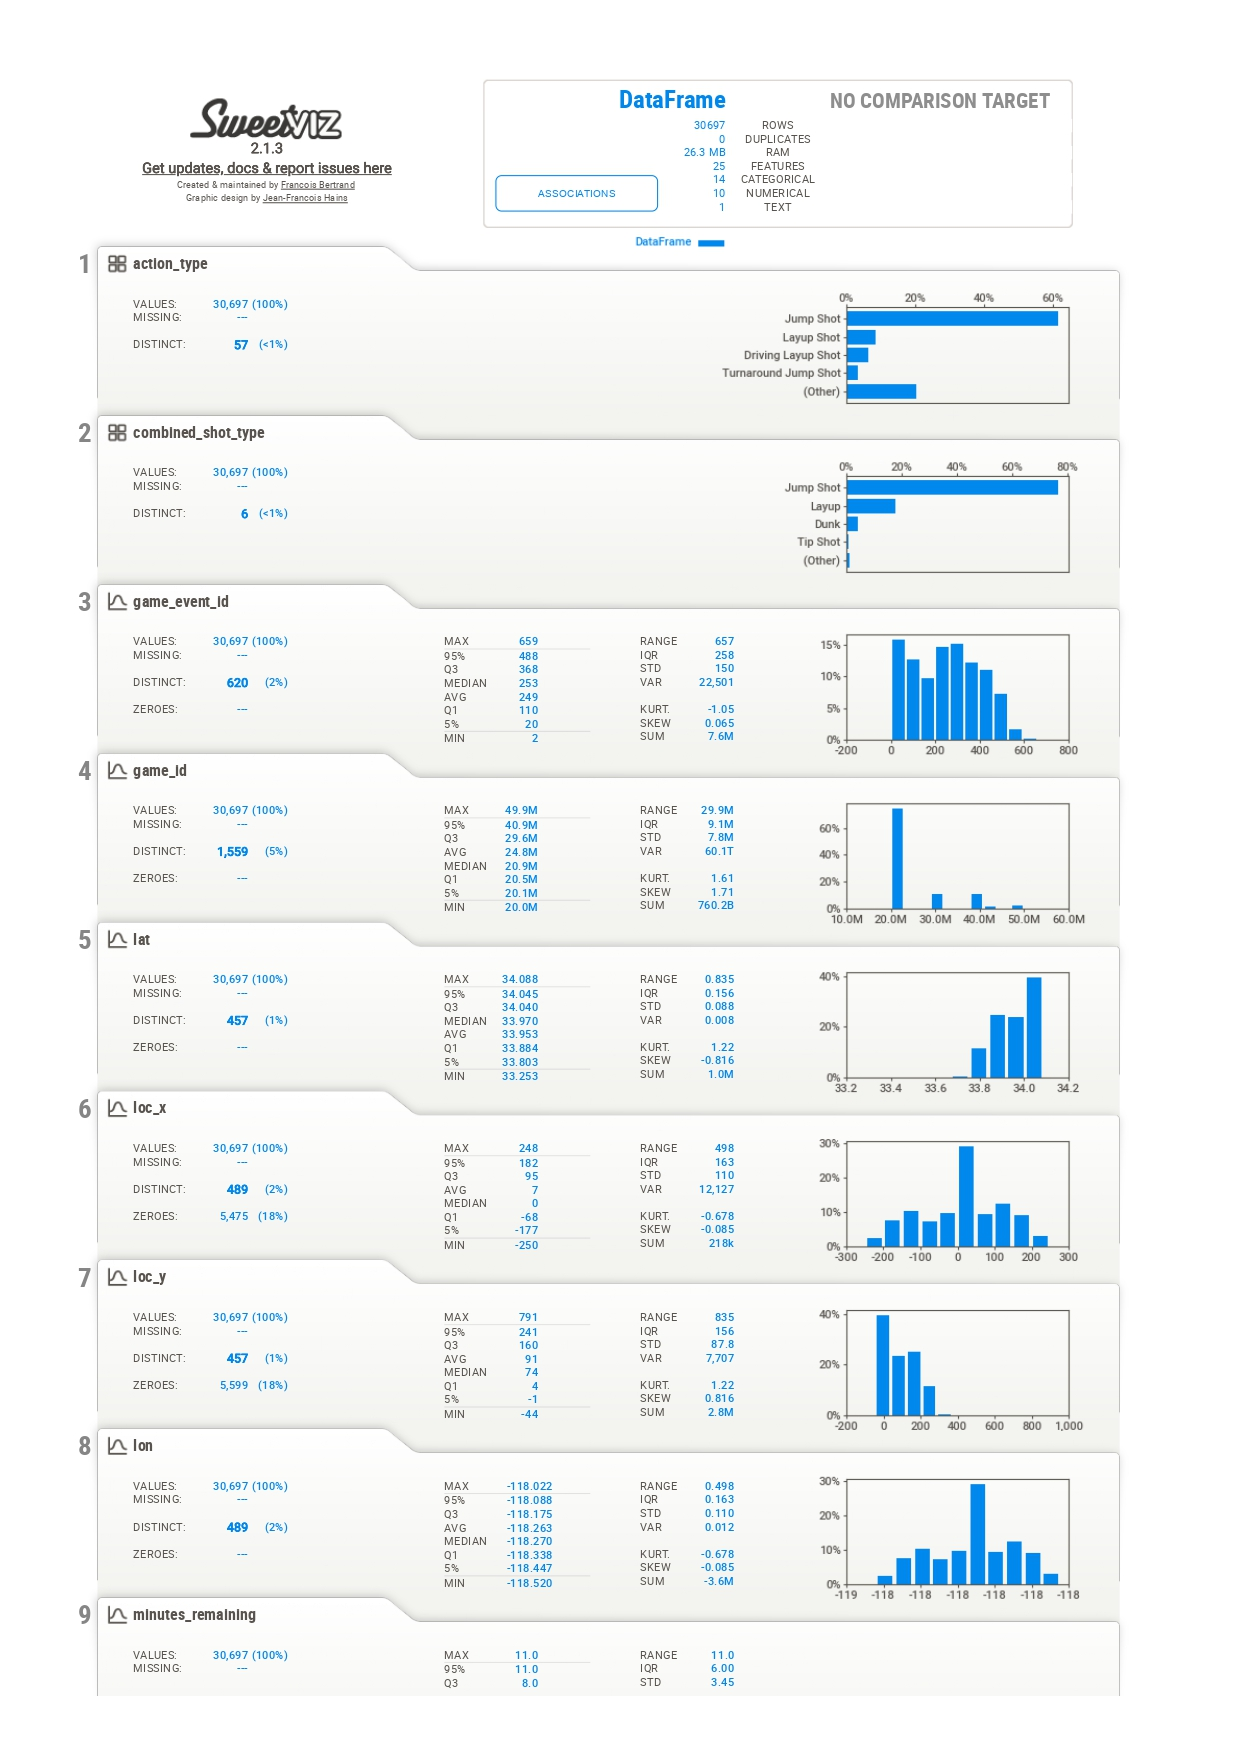

In [170]:
Image("/content/eda_coby_brain_shots_page-0001.jpg")

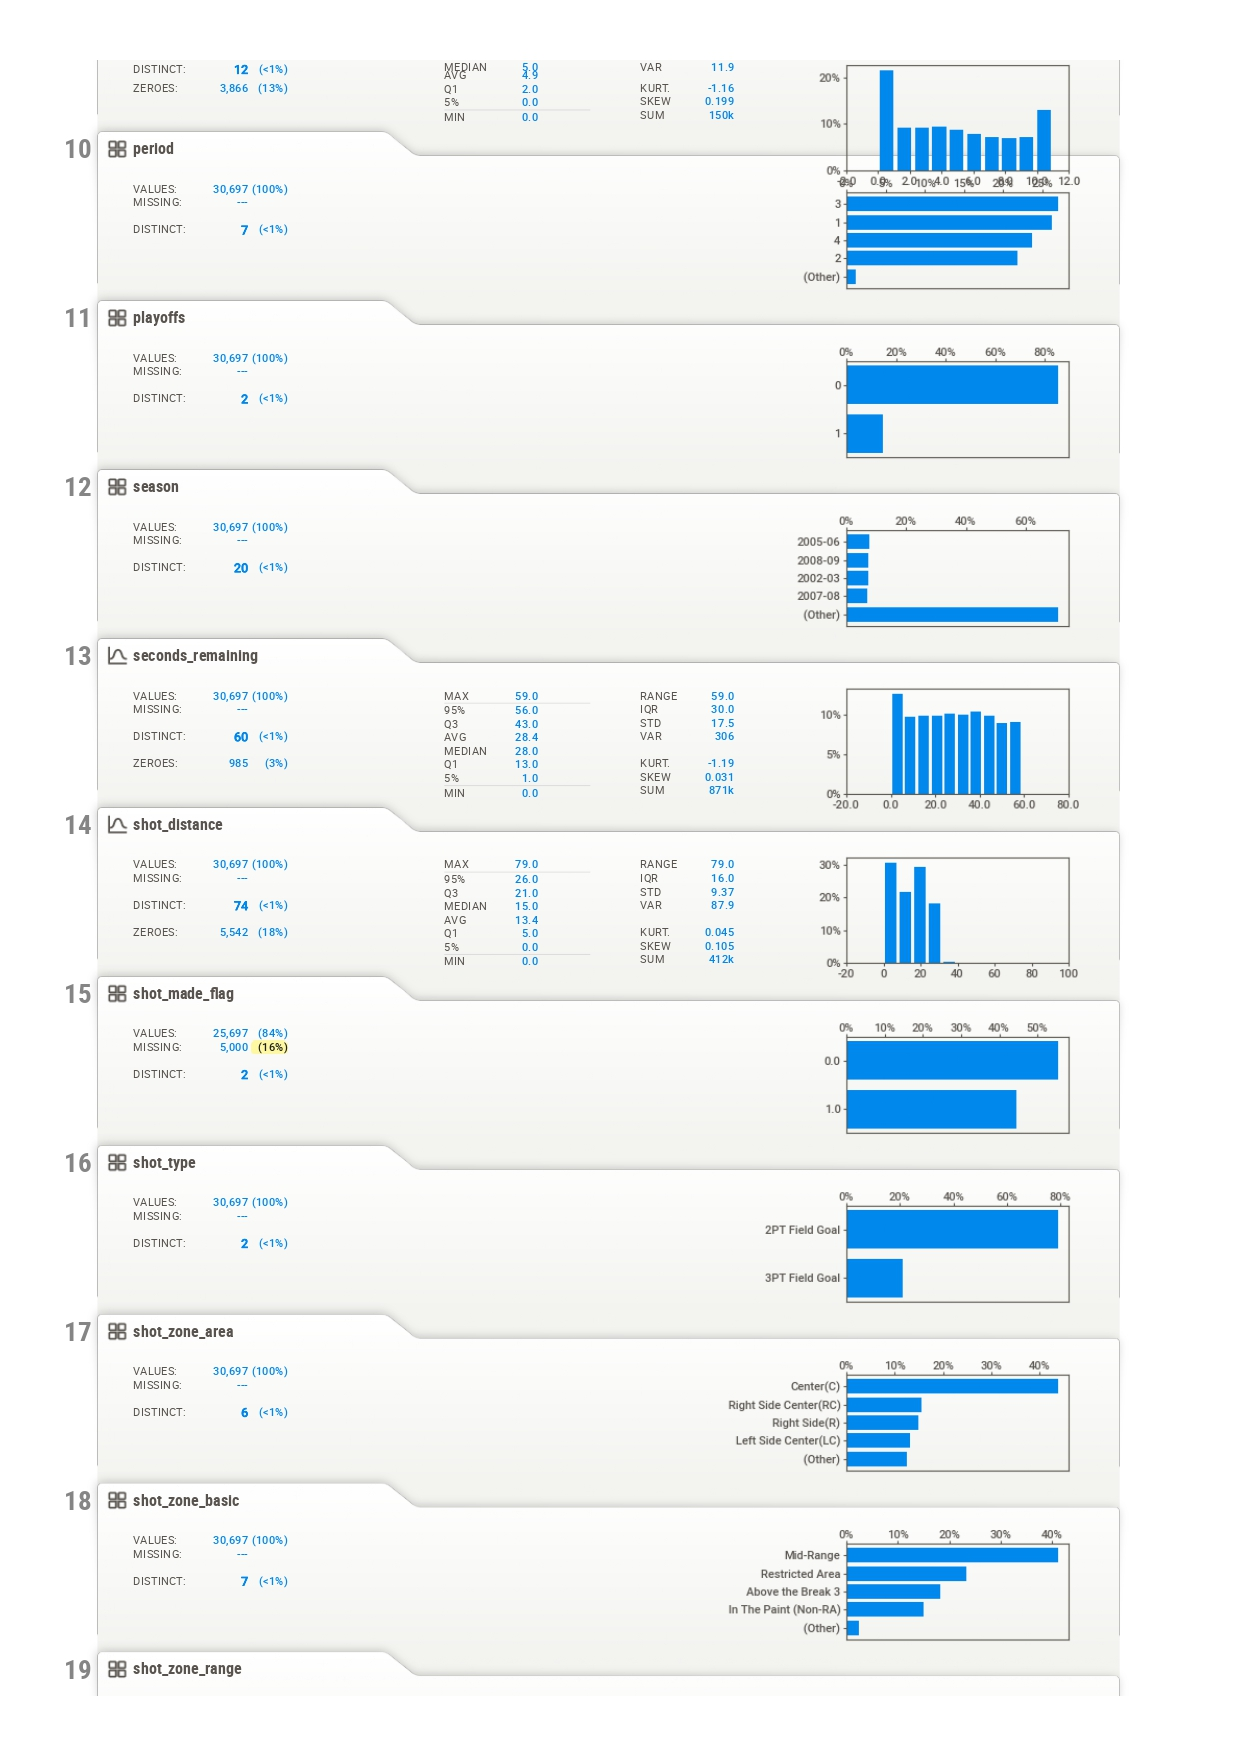

In [171]:
Image("/content/eda_coby_brain_shots_page-0002.jpg")

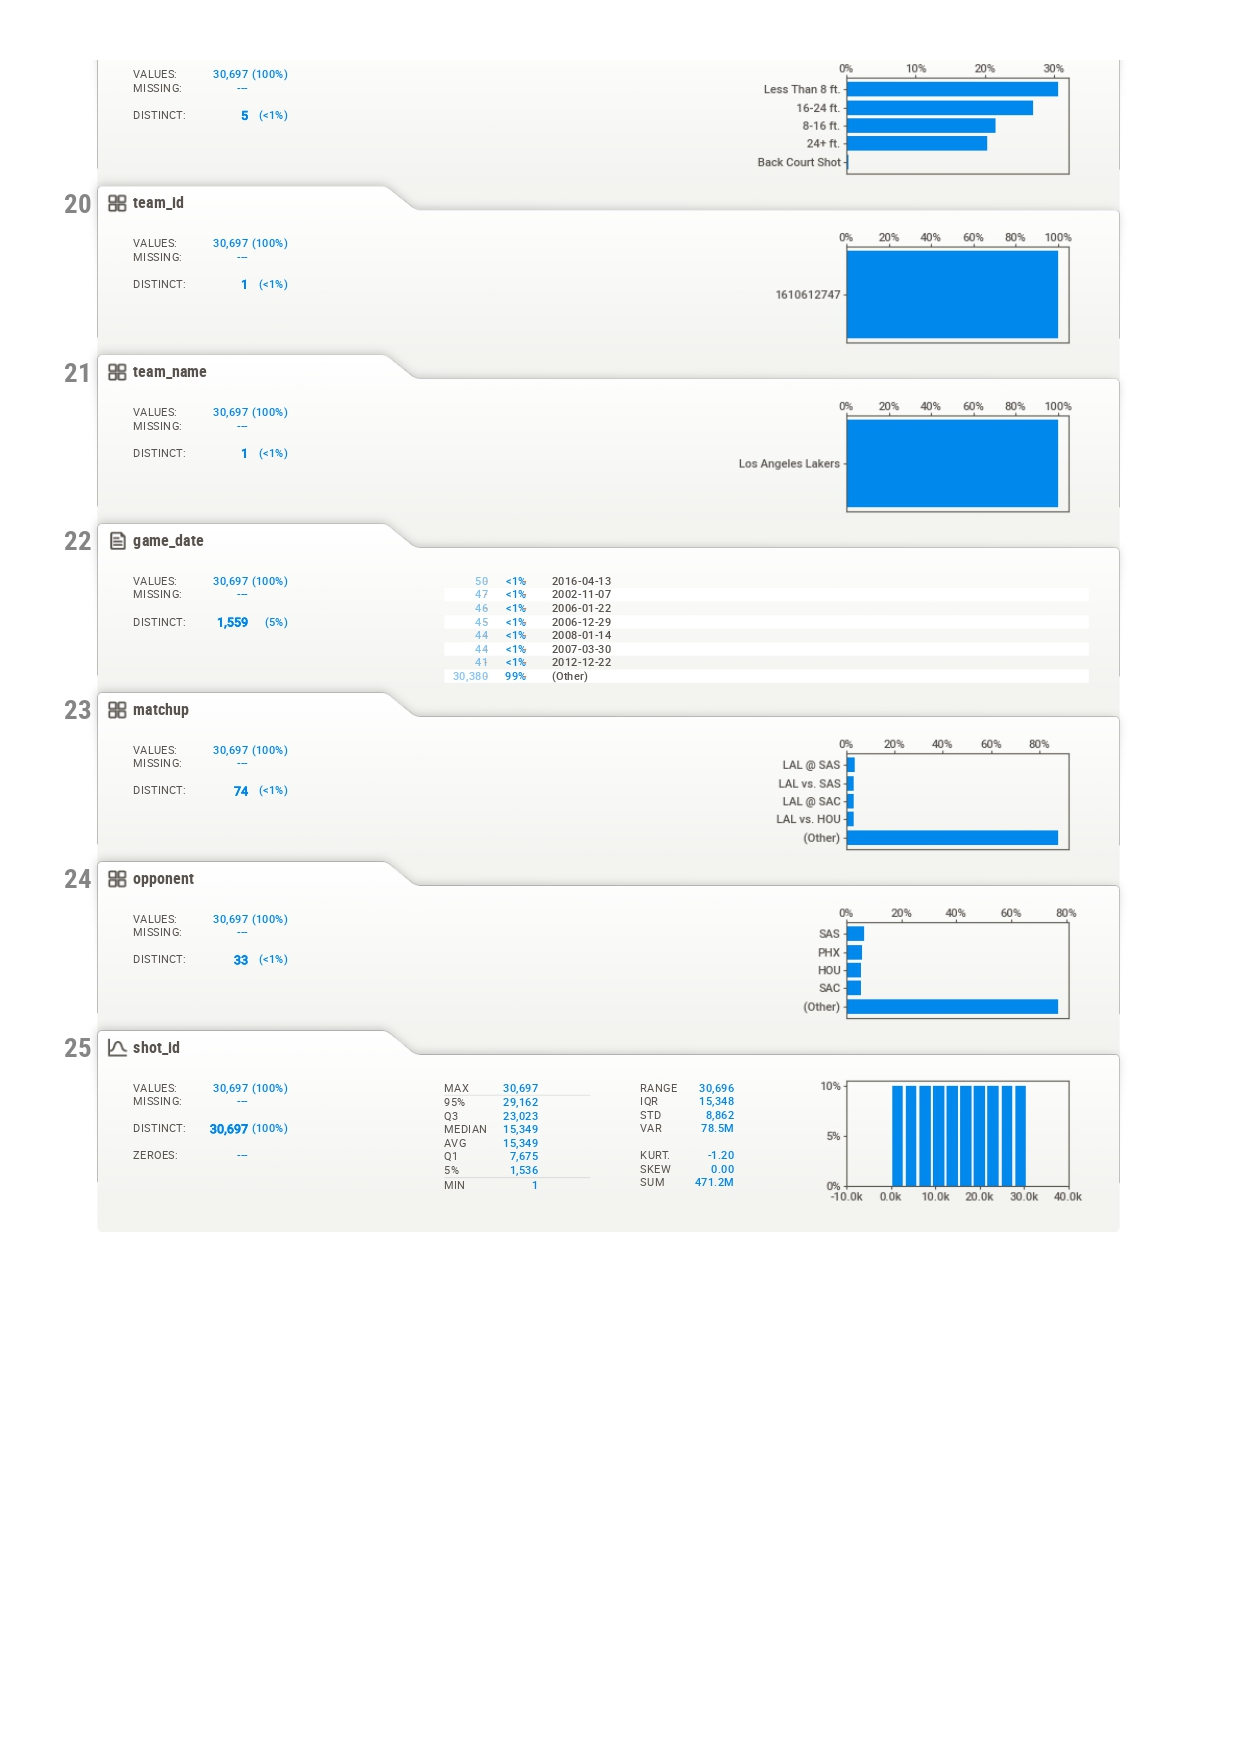

In [172]:
Image("/content/eda_coby_brain_shots_page-0003.jpg")

In [52]:
dataset.dropna(inplace=True)

In [53]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         25697 non-null  object 
 1   combined_shot_type  25697 non-null  object 
 2   game_event_id       25697 non-null  int64  
 3   game_id             25697 non-null  int64  
 4   lat                 25697 non-null  float64
 5   loc_x               25697 non-null  int64  
 6   loc_y               25697 non-null  int64  
 7   lon                 25697 non-null  float64
 8   minutes_remaining   25697 non-null  int64  
 9   period              25697 non-null  int64  
 10  playoffs            25697 non-null  int64  
 11  season              25697 non-null  object 
 12  seconds_remaining   25697 non-null  int64  
 13  shot_distance       25697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           25697 non-null  object 
 16  shot

In [54]:
dataset.shot_made_flag.value_counts()

0.0    14232
1.0    11465
Name: shot_made_flag, dtype: int64

In [55]:
shot_missed = dataset.shot_made_flag.value_counts()[0]

###**a. Conte quantos arremessos foram convertidos (shot_made_flag)**

In [56]:
shot_converted = dataset.shot_made_flag.value_counts()[1]
shot_converted

11465

###**b. Calcule qual foi a taxa de sucesso (eficiência) para todos os arremessos (total de arremessos convertidos/ total de arremessos feitos)**

In [57]:
success_rate =  ((shot_converted / (shot_missed + shot_converted))*100).round(2)

In [58]:
print('Taxa de sucesso: ' + str(success_rate) + '%')

Taxa de sucesso: 44.62%


In [59]:
df = dataset[dataset['shot_made_flag'] == 1.0]

In [60]:
df

action_type combined_shot_type  game_event_id   game_id      lat  \
2              Jump Shot          Jump Shot             35  20000012  33.9093   
4      Driving Dunk Shot               Dunk            155  20000012  34.0443   
6             Layup Shot              Layup            251  20000012  34.0443   
8              Jump Shot          Jump Shot            265  20000012  33.9363   
11             Jump Shot          Jump Shot              4  20000019  33.9173   
...                  ...                ...            ...       ...      ...   
30674          Jump Shot          Jump Shot             81  49900088  33.8283   
30676  Running Jump Shot          Jump Shot             98  49900088  34.0443   
30681          Jump Shot          Jump Shot            218  49900088  33.7833   
30688          Jump Shot          Jump Shot            308  49900088  33.9833   
30694  Running Jump Shot          Jump Shot            426  49900088  33.8783   

       loc_x  loc_y       lon  minutes_remaining  period  ...       shot_type  \
2       -101    135 -118.3708                  7       1  ...  2PT Field Goal   
4          0      0 -118.2698                  6       2  ...  2PT Field Goal   
6          0      0 -118.2698                  8       3  ...  2PT Field Goal   
8        -65    108 -118.3348                  6       3  ...  2PT Field Goal   
11       121    127 -118.1488                 11       1  ...  2PT Field Goal   
...      ...    ...       ...                ...     ...  ...             ...   
30674    117    216 -118.1528                  2       1  ...  3PT Field Goal   
30676   -141      0 -118.4108                  0       1  ...  2PT Field Goal   
30681    -18    261 -118.2878                  0       2  ...  3PT Field Goal   
30688   -126     61 -118.3958                  1       3  ...  2PT Field Goal   
30694   -134    166 -118.4038                  3       4  ...  2PT Field Goal   

              shot_zone_area        shot_zone_basic  shot_zone_range  \
2       Left Side Center(LC)              Mid-Range        16-24 ft.   
4                  Center(C)        Restricted Area  Less Than 8 ft.   
6                  Center(C)        Restricted Area  Less Than 8 ft.   
8               Left Side(L)  In The Paint (Non-RA)         8-16 ft.   
11     Right Side Center(RC)              Mid-Range        16-24 ft.   
...                      ...                    ...              ...   
30674  Right Side Center(RC)      Above the Break 3          24+ ft.   
30676           Left Side(L)              Mid-Range         8-16 ft.   
30681              Center(C)      Above the Break 3          24+ ft.   
30688           Left Side(L)              Mid-Range         8-16 ft.   
30694   Left Side Center(LC)              Mid-Range        16-24 ft.   

          team_id           team_name   game_date      matchup opponent  \
2      1610612747  Los Angeles Lakers  2000-10-31    LAL @ POR      POR   
4      1610612747  Los Angeles Lakers  2000-10-31    LAL @ POR      POR   
6      1610612747  Los Angeles Lakers  2000-10-31    LAL @ POR      POR   
8      1610612747  Los Angeles Lakers  2000-10-31    LAL @ POR      POR   
11     1610612747  Los Angeles Lakers  2000-11-01  LAL vs. UTA      UTA   
...           ...                 ...         ...          ...      ...   
30674  1610612747  Los Angeles Lakers  2000-06-19  LAL vs. IND      IND   
30676  1610612747  Los Angeles Lakers  2000-06-19  LAL vs. IND      IND   
30681  1610612747  Los Angeles Lakers  2000-06-19  LAL vs. IND      IND   
30688  1610612747  Los Angeles Lakers  2000-06-19  LAL vs. IND      IND   
30694  1610612747  Los Angeles Lakers  2000-06-19  LAL vs. IND      IND   

       shot_id  
2            3  
4            5  
6            7  
8            9  
11          12  
...        ...  
30674    30675  
30676    30677  
30681    30682  
30688    30689  
30694    30695  

[11465 rows x 25 columns]

###**c. Qual foi o arremesso convertido mais distante?**

In [156]:
df1 = dataset.groupby('shot_made_flag')['shot_distance'].max()

In [157]:
df1

shot_made_flag
0.0    79
1.0    43
Name: shot_distance, dtype: int64

In [158]:
shot_converted_distance_max = df1[df1.index[1]]

In [159]:
shot_converted_distance_max

43

In [160]:
px.bar(data_frame=df1.reset_index(), x='shot_made_flag', y='shot_distance')

###**d. Qual o quarto do jogo que o Kobe Bryant é mais eficiente?**

In [65]:
df2 = df.groupby('period')['shot_made_flag'].count()

In [66]:
df2.sort_values(ascending=False, inplace=True)

In [67]:
df2

period
3    3175
1    3120
2    2529
4    2500
5     124
6      14
7       3
Name: shot_made_flag, dtype: int64

In [68]:
q3 = df2.index[0]

In [69]:
q3

3

In [70]:
df2.values.max()

3175

In [161]:
px.bar(data_frame=df2.reset_index(), x='period', y='shot_made_flag')

###**e. Agrupe pelo tipo de arremesso e descubra qual tipo de arremesso que o Kobe Bryant é mais eficiente.**

In [71]:
df3 = df.groupby('shot_type')['shot_made_flag'].count()

In [72]:
df3 

shot_type
2PT Field Goal    9683
3PT Field Goal    1782
Name: shot_made_flag, dtype: int64

In [73]:
df3.index[0]

'2PT Field Goal'

In [162]:
px.bar(data_frame=df3.reset_index(), x='shot_type', y='shot_made_flag')

###**f. Qual foi a melhor temporada do Kobe Bryant em relação a percentual de cestas convertidas?**

In [74]:
df4 = df.groupby('season')['shot_made_flag'].count()

In [75]:
df4.sort_values(ascending=False, inplace=True)

In [76]:
df4

season
2005-06    873
2008-09    866
2007-08    852
2002-03    808
2009-10    804
2001-02    783
2000-01    735
2006-07    723
2010-11    679
2012-13    608
1999-00    604
2011-12    603
2003-04    594
2004-05    492
1998-99    351
1997-98    349
2015-16    332
2014-15    223
1996-97    162
2013-14     24
Name: shot_made_flag, dtype: int64

In [77]:
df4.index[0]

'2005-06'

In [78]:
df4.values.max()

873

In [163]:
px.bar(data_frame=df4.reset_index(), x='season', y='shot_made_flag')

###**g. Conte o tipo de arremesso por temporada**

In [201]:
df5 = dataset.groupby(['season','shot_type'])['shot_type'].agg('count')

In [202]:
df5

season   shot_type     
1996-97  2PT Field Goal     256
         3PT Field Goal     127
1997-98  2PT Field Goal     617
         3PT Field Goal     193
1998-99  2PT Field Goal     654
         3PT Field Goal     111
1999-00  2PT Field Goal    1135
         3PT Field Goal     177
2000-01  2PT Field Goal    1380
         3PT Field Goal     195
2001-02  2PT Field Goal    1547
         3PT Field Goal     161
2002-03  2PT Field Goal    1531
         3PT Field Goal     321
2003-04  2PT Field Goal    1105
         3PT Field Goal     266
2004-05  2PT Field Goal     793
         3PT Field Goal     334
2005-06  2PT Field Goal    1459
         3PT Field Goal     465
2006-07  2PT Field Goal    1230
         3PT Field Goal     349
2007-08  2PT Field Goal    1387
         3PT Field Goal     432
2008-09  2PT Field Goal    1479
         3PT Field Goal     372
2009-10  2PT Field Goal    1406
         3PT Field Goal     366
2010-11  2PT Field Goal    1191
         3PT Field Goal     330
2011-12  2PT Fie

###**h. Faça dois gráficos: posição em quadra dos arremessos perdidos x posição em quadra dos arremessos acertados (o eixo X é a largura da quadra, e o Y é a distânca para o fundo de quadra).**

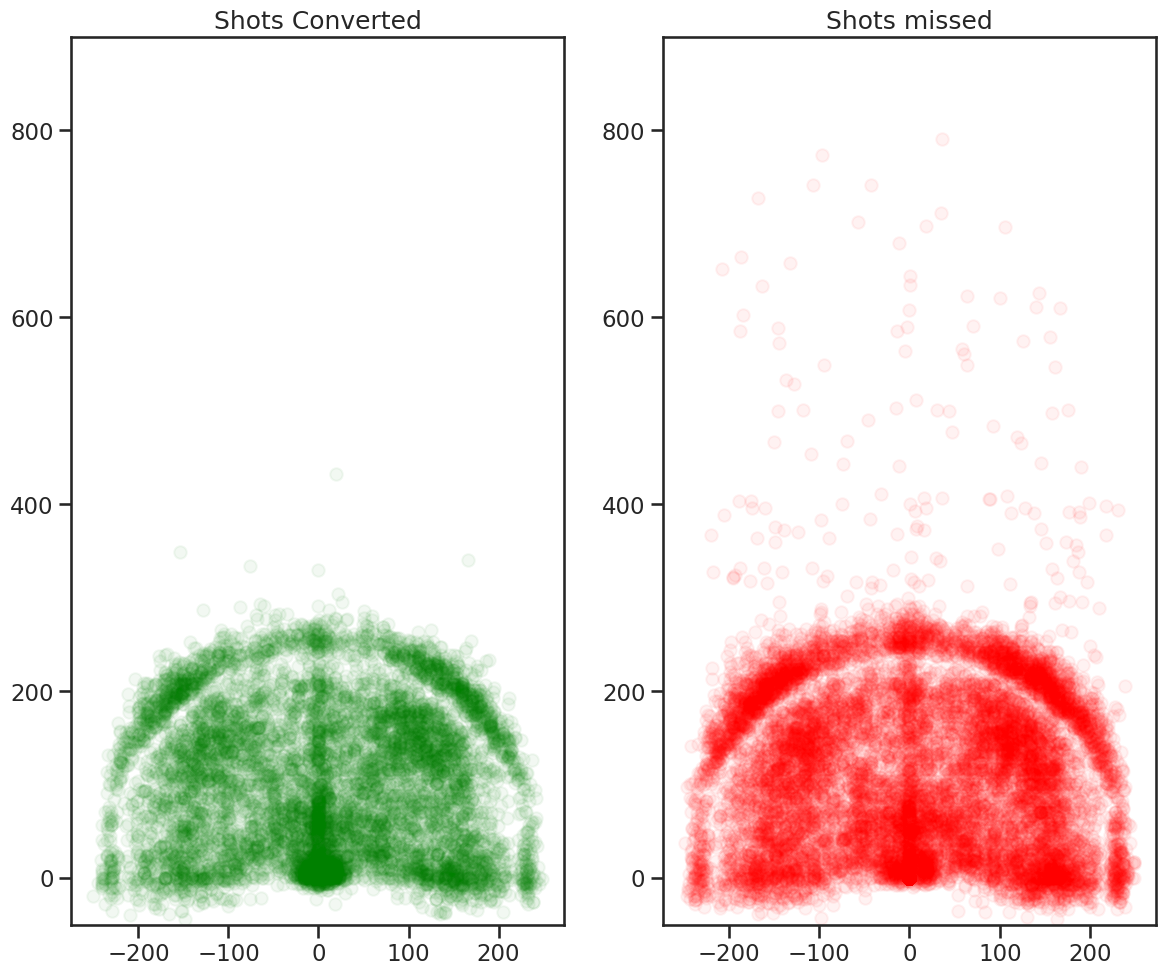

In [210]:
court_scale, alpha = 7, 0.05
plt.figure(figsize=(2 * court_scale, court_scale*(84.0/50.0)))
# hit
plt.subplot(121)
shots_converted = dataset.loc[dataset.shot_made_flag == 1]
plt.scatter(shots_converted.loc_x, shots_converted.loc_y, color='green', alpha=alpha)
plt.title('Shots Converted')
ax = plt.gca()
ax.set_ylim([-50, 900])
# miss
plt.subplot(122)
shots_missed = dataset.loc[dataset.shot_made_flag == 0]
plt.scatter(shots_missed.loc_x, shots_missed.loc_y, color='red', alpha=alpha)
plt.title('Shots missed')
ax = plt.gca()
ax.set_ylim([-50, 900])
plt.savefig('shots_converted_and_missed.png')

In [82]:
shots_converted

action_type combined_shot_type  game_event_id   game_id      lat  \
2              Jump Shot          Jump Shot             35  20000012  33.9093   
4      Driving Dunk Shot               Dunk            155  20000012  34.0443   
6             Layup Shot              Layup            251  20000012  34.0443   
8              Jump Shot          Jump Shot            265  20000012  33.9363   
11             Jump Shot          Jump Shot              4  20000019  33.9173   
...                  ...                ...            ...       ...      ...   
30674          Jump Shot          Jump Shot             81  49900088  33.8283   
30676  Running Jump Shot          Jump Shot             98  49900088  34.0443   
30681          Jump Shot          Jump Shot            218  49900088  33.7833   
30688          Jump Shot          Jump Shot            308  49900088  33.9833   
30694  Running Jump Shot          Jump Shot            426  49900088  33.8783   

       loc_x  loc_y       lon  minutes_remaining  period  ...       shot_type  \
2       -101    135 -118.3708                  7       1  ...  2PT Field Goal   
4          0      0 -118.2698                  6       2  ...  2PT Field Goal   
6          0      0 -118.2698                  8       3  ...  2PT Field Goal   
8        -65    108 -118.3348                  6       3  ...  2PT Field Goal   
11       121    127 -118.1488                 11       1  ...  2PT Field Goal   
...      ...    ...       ...                ...     ...  ...             ...   
30674    117    216 -118.1528                  2       1  ...  3PT Field Goal   
30676   -141      0 -118.4108                  0       1  ...  2PT Field Goal   
30681    -18    261 -118.2878                  0       2  ...  3PT Field Goal   
30688   -126     61 -118.3958                  1       3  ...  2PT Field Goal   
30694   -134    166 -118.4038                  3       4  ...  2PT Field Goal   

              shot_zone_area        shot_zone_basic  shot_zone_range  \
2       Left Side Center(LC)              Mid-Range        16-24 ft.   
4                  Center(C)        Restricted Area  Less Than 8 ft.   
6                  Center(C)        Restricted Area  Less Than 8 ft.   
8               Left Side(L)  In The Paint (Non-RA)         8-16 ft.   
11     Right Side Center(RC)              Mid-Range        16-24 ft.   
...                      ...                    ...              ...   
30674  Right Side Center(RC)      Above the Break 3          24+ ft.   
30676           Left Side(L)              Mid-Range         8-16 ft.   
30681              Center(C)      Above the Break 3          24+ ft.   
30688           Left Side(L)              Mid-Range         8-16 ft.   
30694   Left Side Center(LC)              Mid-Range        16-24 ft.   

          team_id           team_name   game_date      matchup opponent  \
2      1610612747  Los Angeles Lakers  2000-10-31    LAL @ POR      POR   
4      1610612747  Los Angeles Lakers  2000-10-31    LAL @ POR      POR   
6      1610612747  Los Angeles Lakers  2000-10-31    LAL @ POR      POR   
8      1610612747  Los Angeles Lakers  2000-10-31    LAL @ POR      POR   
11     1610612747  Los Angeles Lakers  2000-11-01  LAL vs. UTA      UTA   
...           ...                 ...         ...          ...      ...   
30674  1610612747  Los Angeles Lakers  2000-06-19  LAL vs. IND      IND   
30676  1610612747  Los Angeles Lakers  2000-06-19  LAL vs. IND      IND   
30681  1610612747  Los Angeles Lakers  2000-06-19  LAL vs. IND      IND   
30688  1610612747  Los Angeles Lakers  2000-06-19  LAL vs. IND      IND   
30694  1610612747  Los Angeles Lakers  2000-06-19  LAL vs. IND      IND   

       shot_id  
2            3  
4            5  
6            7  
8            9  
11          12  
...        ...  
30674    30675  
30676    30677  
30681    30682  
30688    30689  
30694    30695  

[11465 rows x 25 columns]

###**i. Qual a distância média dos arremessos convertidos?**

In [83]:
shot_distance_converted_avg = shots_converted['shot_distance'].mean()

In [84]:
round(shot_distance_converted_avg,2)

11.38

###**Qual a distância média dos arremessos não-convertidos?**

In [85]:
shot_distance_missed_avg = shots_missed['shot_distance'].mean()

In [86]:
round(shot_distance_missed_avg,2)

15.13

###**2. Com os dados do sistema de energia renovável da california: https://www.kaggle.com/cheedcheed/california-renewableproduction-20102018. Considere apenas datas maiores que 2013.**
###**Faça:**

In [87]:
df_breakdown = pd.read_csv('/content/all_breakdown.csv')

In [88]:
df_breakdown.head()

TIMESTAMP  BIOGAS  BIOMASS  GEOTHERMAL  Hour  SMALL HYDRO  SOLAR  \
0  2011-07-21 00:00:00   177.0    372.0       984.0   1.0        516.0    0.0   
1  2011-07-21 01:00:00   176.0    373.0       984.0   2.0        509.0    0.0   
2  2011-07-21 02:00:00   177.0    371.0       985.0   3.0        506.0    0.0   
3  2011-07-21 03:00:00   177.0    374.0       985.0   4.0        504.0    0.0   
4  2011-07-21 04:00:00   177.0    377.0       984.0   5.0        508.0    0.0   

   SOLAR PV  SOLAR THERMAL  WIND TOTAL  
0       NaN            NaN      1607.0  
1       NaN            NaN      1619.0  
2       NaN            NaN      1660.0  
3       NaN            NaN      1633.0  
4       NaN            NaN      1520.0

In [89]:
df_breakdown.tail()

TIMESTAMP  BIOGAS  BIOMASS  GEOTHERMAL  Hour  SMALL HYDRO  \
67579  2013-01-28 19:00:00   209.0    331.0       924.0  20.0        404.0   
67580  2013-01-28 20:00:00   207.0    334.0       924.0  21.0        372.0   
67581  2013-01-28 21:00:00   208.0    342.0       926.0  22.0        372.0   
67582  2013-01-28 22:00:00   208.0    334.0       928.0  23.0        358.0   
67583  2013-01-28 23:00:00   208.0    335.0       928.0  24.0        331.0   

       SOLAR  SOLAR PV  SOLAR THERMAL  WIND TOTAL  
67579    NaN       0.0            0.0      2633.0  
67580    NaN       0.0            0.0      2540.0  
67581    NaN       0.0            0.0      2408.0  
67582    NaN       0.0            0.0      2274.0  
67583    NaN       0.0            0.0      2230.0

###**Visualização de dados**

In [90]:
report = sv.analyze(df_breakdown)
report.show_html('eda_breakdown.html')

                                             |          | [  0%]   00:00 -> (? left)

Report eda_breakdown.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


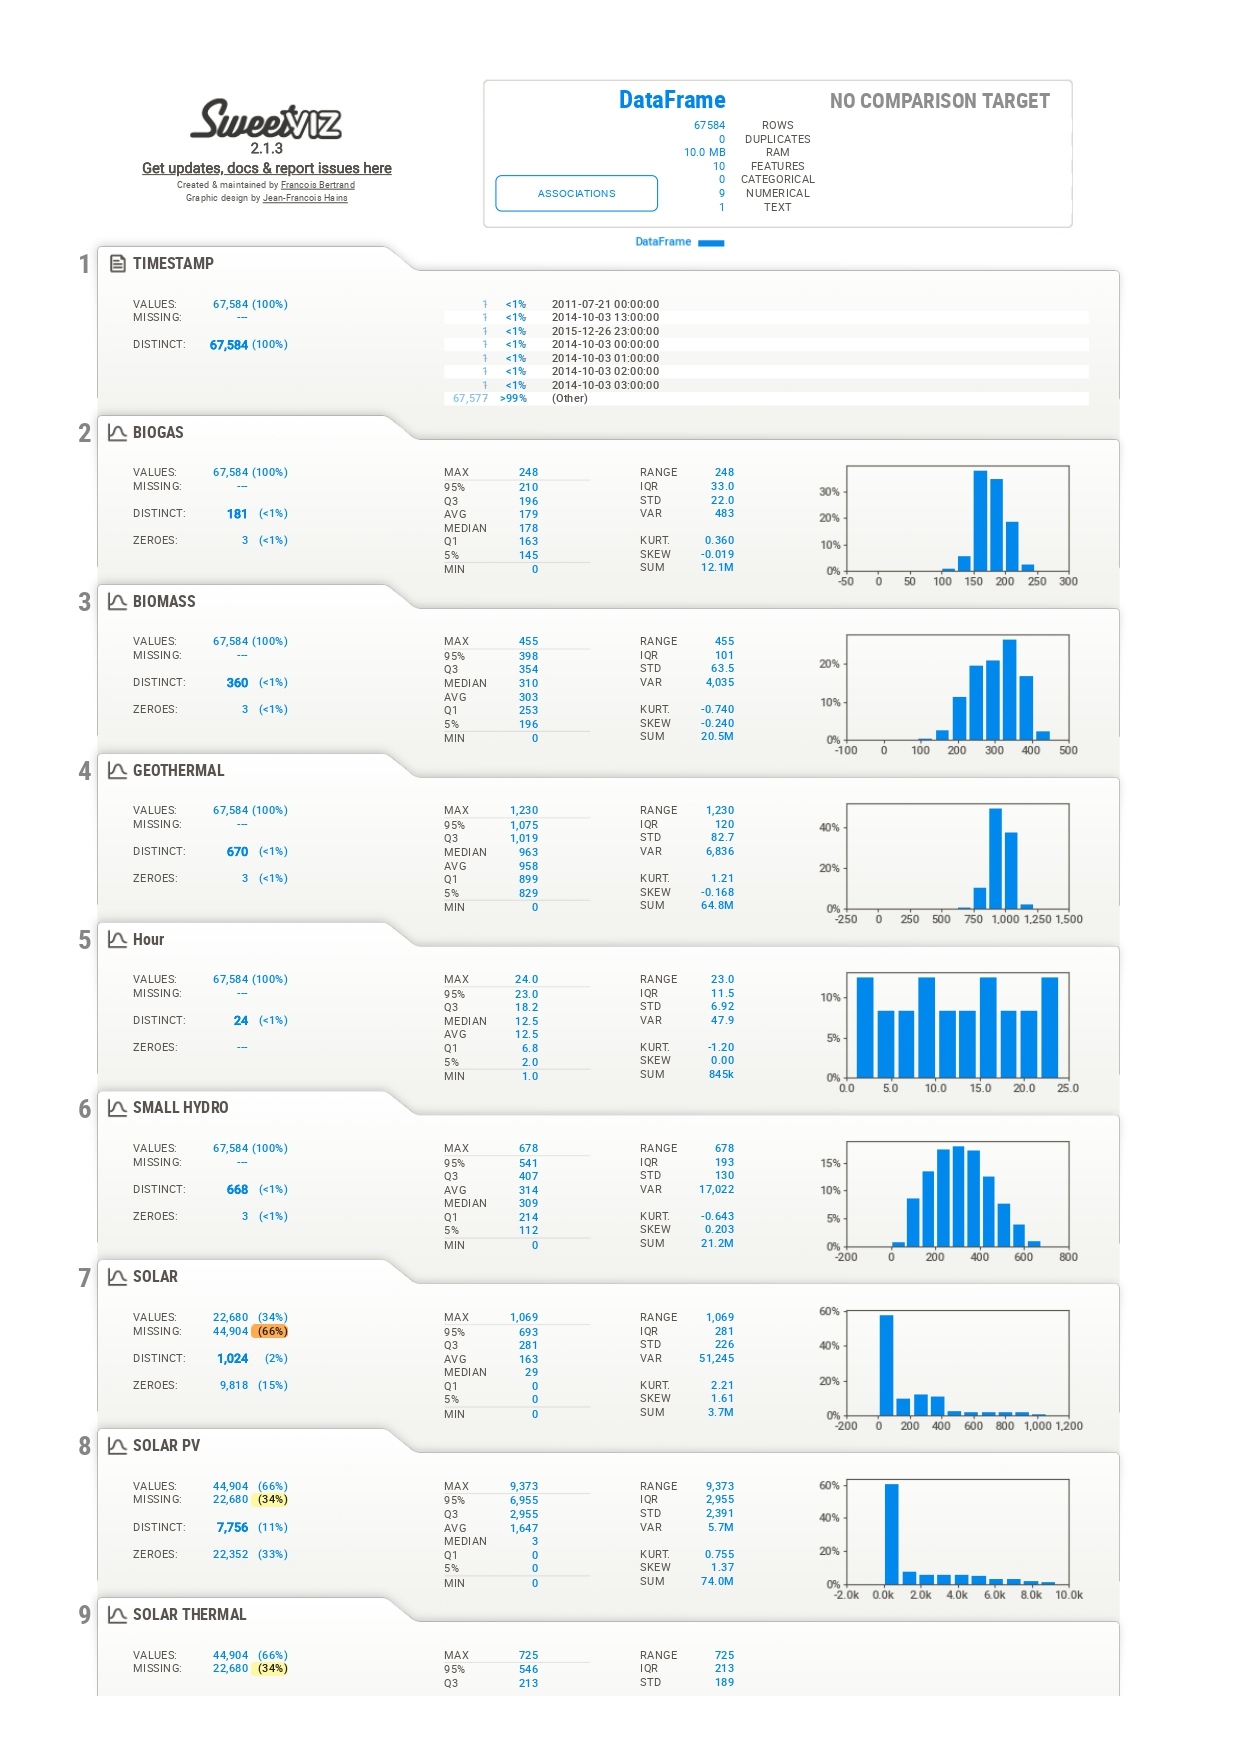

In [169]:
Image("/content/eda_breakdown_page-0001.jpg")

###**a. Crie uma nova coluna "SOLAR TOTAL" resultante da soma das colunas "SOLAR PV", "SOLAR THERMAL" e "SOLAR"**

In [92]:
ds = df_breakdown.copy()

In [93]:
ds['SOLAR TOTAL'] = ds['SOLAR'].replace(np.nan, 0.0) + ds['SOLAR PV'].replace(np.nan, 0.0) + ds['SOLAR THERMAL'].replace(np.nan, 0.0)

In [94]:
ds

TIMESTAMP  BIOGAS  BIOMASS  GEOTHERMAL  Hour  SMALL HYDRO  \
0      2011-07-21 00:00:00   177.0    372.0       984.0   1.0        516.0   
1      2011-07-21 01:00:00   176.0    373.0       984.0   2.0        509.0   
2      2011-07-21 02:00:00   177.0    371.0       985.0   3.0        506.0   
3      2011-07-21 03:00:00   177.0    374.0       985.0   4.0        504.0   
4      2011-07-21 04:00:00   177.0    377.0       984.0   5.0        508.0   
...                    ...     ...      ...         ...   ...          ...   
67579  2013-01-28 19:00:00   209.0    331.0       924.0  20.0        404.0   
67580  2013-01-28 20:00:00   207.0    334.0       924.0  21.0        372.0   
67581  2013-01-28 21:00:00   208.0    342.0       926.0  22.0        372.0   
67582  2013-01-28 22:00:00   208.0    334.0       928.0  23.0        358.0   
67583  2013-01-28 23:00:00   208.0    335.0       928.0  24.0        331.0   

       SOLAR  SOLAR PV  SOLAR THERMAL  WIND TOTAL  SOLAR TOTAL  
0        0.0       NaN            NaN      1607.0          0.0  
1        0.0       NaN            NaN      1619.0          0.0  
2        0.0       NaN            NaN      1660.0          0.0  
3        0.0       NaN            NaN      1633.0          0.0  
4        0.0       NaN            NaN      1520.0          0.0  
...      ...       ...            ...         ...          ...  
67579    NaN       0.0            0.0      2633.0          0.0  
67580    NaN       0.0            0.0      2540.0          0.0  
67581    NaN       0.0            0.0      2408.0          0.0  
67582    NaN       0.0            0.0      2274.0          0.0  
67583    NaN       0.0            0.0      2230.0          0.0  

[67584 rows x 11 columns]

In [95]:
ds.isna().sum()

TIMESTAMP            0
BIOGAS               0
BIOMASS              0
GEOTHERMAL           0
Hour                 0
SMALL HYDRO          0
SOLAR            44904
SOLAR PV         22680
SOLAR THERMAL    22680
WIND TOTAL           0
SOLAR TOTAL          0
dtype: int64

###**b. Converta a coluna TIMESTAMP para datetime**

In [96]:
ds['TIMESTAMP'] = pd.to_datetime(ds.TIMESTAMP)

In [97]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67584 entries, 0 to 67583
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TIMESTAMP      67584 non-null  datetime64[ns]
 1   BIOGAS         67584 non-null  float64       
 2   BIOMASS        67584 non-null  float64       
 3   GEOTHERMAL     67584 non-null  float64       
 4   Hour           67584 non-null  float64       
 5   SMALL HYDRO    67584 non-null  float64       
 6   SOLAR          22680 non-null  float64       
 7   SOLAR PV       44904 non-null  float64       
 8   SOLAR THERMAL  44904 non-null  float64       
 9   WIND TOTAL     67584 non-null  float64       
 10  SOLAR TOTAL    67584 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 5.7 MB


In [98]:
ds = ds[ds['TIMESTAMP'].dt.year > 2013]

In [99]:
ds.sort_values('TIMESTAMP', ascending=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [100]:
ds.reset_index(drop=True, inplace=True)

In [101]:
ds

TIMESTAMP  BIOGAS  BIOMASS  GEOTHERMAL  Hour  SMALL HYDRO  \
0     2014-01-01 00:00:00   175.0    379.0       849.0   1.0        112.0   
1     2014-01-01 01:00:00   176.0    377.0       849.0   2.0        109.0   
2     2014-01-01 02:00:00   176.0    375.0       849.0   3.0         74.0   
3     2014-01-01 03:00:00   176.0    372.0       849.0   4.0         74.0   
4     2014-01-01 04:00:00   176.0    377.0       849.0   5.0         75.0   
...                   ...     ...      ...         ...   ...          ...   
35347 2018-01-16 19:00:00   240.0    339.0       974.0  20.0        495.0   
35348 2018-01-16 20:00:00   239.0    334.0       976.0  21.0        461.0   
35349 2018-01-16 21:00:00   239.0    334.0       971.0  22.0        451.0   
35350 2018-01-16 22:00:00   241.0    326.0       972.0  23.0        393.0   
35351 2018-01-16 23:00:00   240.0    325.0       972.0  24.0        393.0   

       SOLAR  SOLAR PV  SOLAR THERMAL  WIND TOTAL  SOLAR TOTAL  
0        NaN       0.0            0.0        41.0          0.0  
1        NaN       0.0            0.0        46.0          0.0  
2        NaN       0.0            0.0        45.0          0.0  
3        NaN       0.0            0.0        35.0          0.0  
4        NaN       0.0            0.0        25.0          0.0  
...      ...       ...            ...         ...          ...  
35347    NaN       0.0            0.0       213.0          0.0  
35348    NaN       0.0            0.0       235.0          0.0  
35349    NaN       0.0            0.0       288.0          0.0  
35350    NaN       0.0            0.0       303.0          0.0  
35351    NaN       0.0            0.0       310.0          0.0  

[35352 rows x 11 columns]

###**c. Crie um plot onde o eixo X represente as 24 horas do dia e o eixo Y represente a quantidade de energia (em MWh). Nesse plot, você irá criar um boxplot mostrando a distribuição da energia gerada (variável SOLAR TOTAL) por hora. (Dica 1: Crie uma coluna auxiliar Dica 2 : use seaborn)**

In [102]:
x = ds.index
y = ds['SOLAR TOTAL'.upper()]
hour = ds['Hour'].astype(int)
quart_day = hour // 4

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


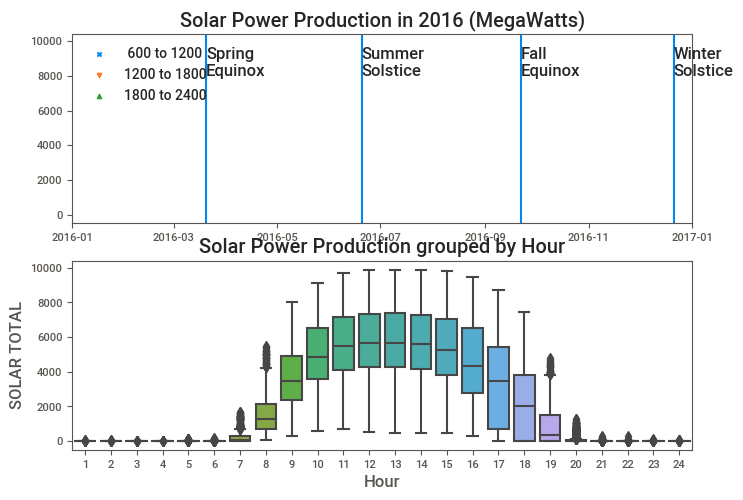

In [103]:
plt.subplot(2, 1, 1)

for h, marker in [(1, 'x'), (2, 'v'), (3, '^')]:
    mask = quart_day == h
    plt.scatter(x[mask], y[mask], marker=marker,  # c=hour[mask].norm(),
                label='{:2}00 to {:2}00'.format(h*6, (h+1)*6))
plt.legend(loc='upper left')
plt.xlim([pd.to_datetime('01/01/2016'), pd.to_datetime('01/01/2017')])
plt.title('Solar Power Production in 2016 (MegaWatts)')

# Add the season change lines
seasons = [(pd.to_datetime('June 20, 2016'), 'Summer Solstice'),
           (pd.to_datetime('December 21, 2016'), 'Winter Solstice'),
           (pd.to_datetime('September 22, 2016'), 'Fall Equinox'),
           (pd.to_datetime('March 20, 2016'), 'Spring Equinox'),
           ]

for s, name in seasons:
    plt.axvline(s)
    plt.text(s, 8000, name.replace(' ', '\n'))


plt.subplot(2, 1, 2)
sns.boxplot(hour, y)

plt.title('Solar Power Production grouped by Hour')
plt.show()

In [104]:
ds.loc[ds['SOLAR TOTAL']].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


BIOGAS           180.451827
BIOMASS          348.841876
GEOTHERMAL       872.018896
Hour               6.894122
SMALL HYDRO      151.732066
SOLAR                   NaN
SOLAR PV         614.139087
SOLAR THERMAL     59.596147
WIND TOTAL       770.718969
SOLAR TOTAL      673.735234
dtype: float64

###**d. Re-amostre a série SOLAR TOTAL para a frequencia 1D e faça um gráfico**

In [105]:
dataTime = ds[['TIMESTAMP', 'SOLAR TOTAL']].set_index('TIMESTAMP', inplace=False)
dataTimeMean = pd.DataFrame(dataTime.resample('1D')['SOLAR TOTAL'].sum())

In [106]:
dataTimeMean.head(10)

SOLAR TOTAL
TIMESTAMP              
2014-01-01      18326.0
2014-01-02      20441.0
2014-01-03      16721.0
2014-01-04      15228.0
2014-01-05      18207.0
2014-01-06      17318.0
2014-01-07      11109.0
2014-01-08      17370.0
2014-01-09      15611.0
2014-01-10      18015.0

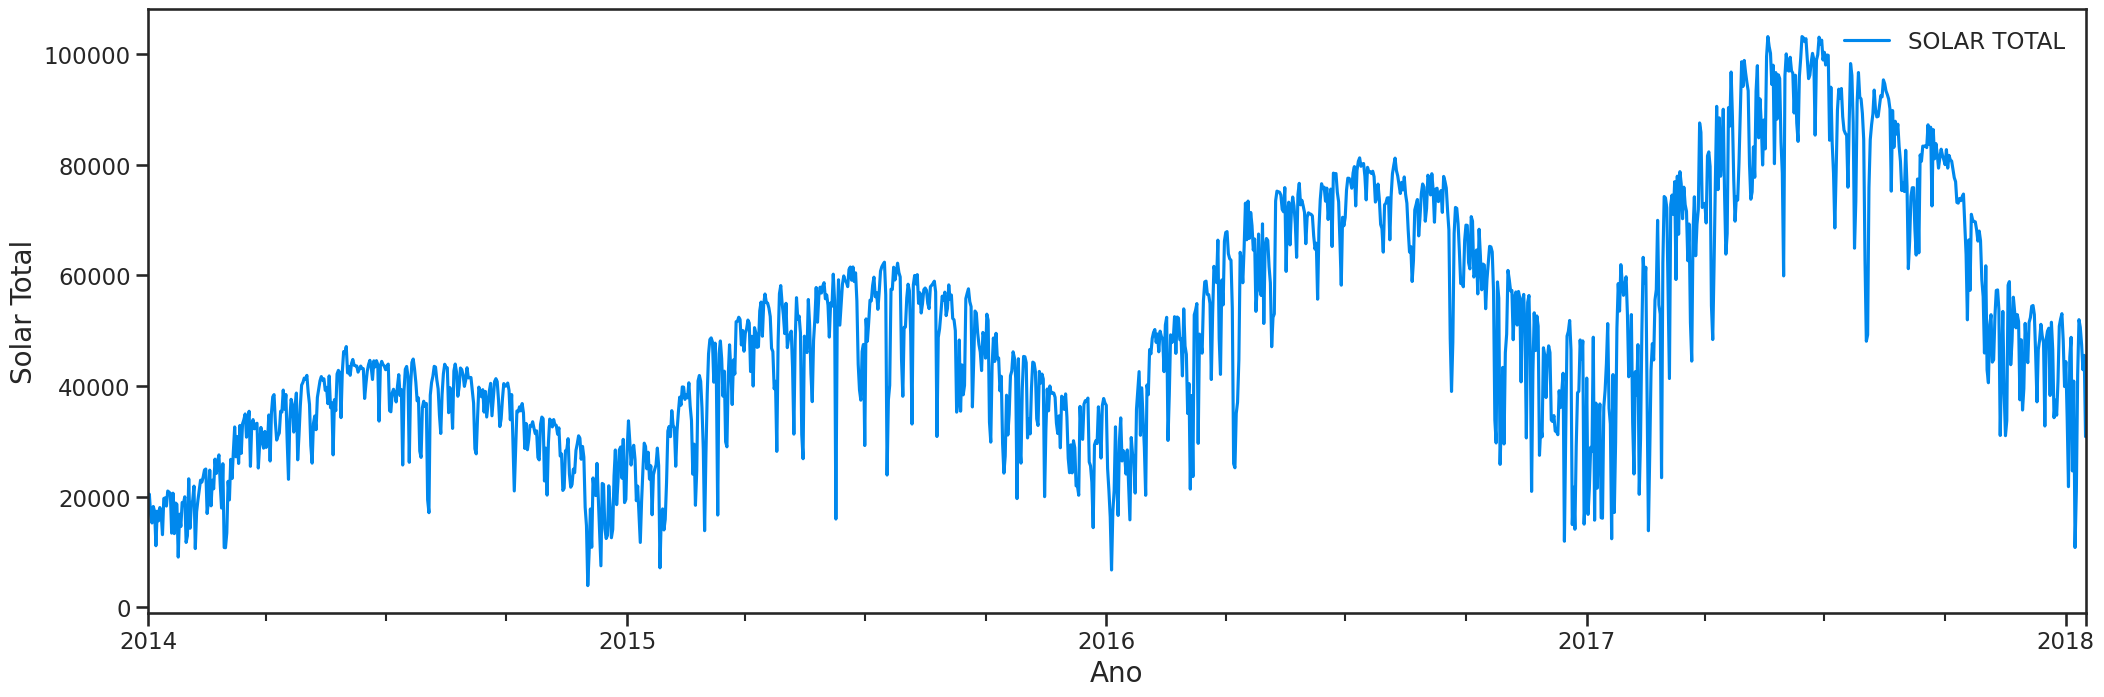

In [180]:
dataTimeMean.reset_index().plot(x='TIMESTAMP', y='SOLAR TOTAL', figsize=(25,8))#, color='#42A5F5', alpha=0.9, ci=None)
plt.xlabel('Ano', size=20)
plt.ylabel('Solar Total', size=20)
plt.show()

**Tratamento dados inconsistentes**

In [107]:
dataTimeMean.loc[dataTimeMean['SOLAR TOTAL'] == 0]

SOLAR TOTAL
TIMESTAMP              
2014-05-21          0.0
2015-03-08          0.0
2016-03-13          0.0
2017-03-12          0.0

In [108]:
dataTimeMean.index.month

Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            ...
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
           dtype='int64', name='TIMESTAMP', length=1477)

In [109]:
dataTimeMean.index.year

Int64Index([2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
            ...
            2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018],
           dtype='int64', name='TIMESTAMP', length=1477)

In [110]:
dataTimeMean.index.day

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
             7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
           dtype='int64', name='TIMESTAMP', length=1477)

In [111]:
dataTimeMean.loc[(dataTimeMean.index.year == 2014) & (dataTimeMean.index.month == 5)].mean()

SOLAR TOTAL    36998.193548
dtype: float64

In [112]:
dataTimeMean.loc[dataTimeMean.index == '2014-05-21', 'SOLAR TOTAL'] = 36998.193548

In [113]:
dataTimeMean.loc[(dataTimeMean.index.year == 2015) & (dataTimeMean.index.month == 3)].mean()

SOLAR TOTAL    40690.064516
dtype: float64

In [114]:
dataTimeMean.loc[dataTimeMean.index == '2015-03-08', 'SOLAR TOTAL'] = 40690.064516 #42046.4

In [115]:
dataTimeMean.loc[(dataTimeMean.index.year == 2016) & (dataTimeMean.index.month == 3)].mean()

SOLAR TOTAL    48105.419355
dtype: float64

In [116]:
dataTimeMean.loc[dataTimeMean.index == '2016-03-13', 'SOLAR TOTAL'] = 48105.419355

In [117]:
dataTimeMean.loc[(dataTimeMean.index.year == 2017) & (dataTimeMean.index.month == 3)].mean()

SOLAR TOTAL    67444.645161
dtype: float64

In [118]:
dataTimeMean.loc[dataTimeMean.index == '2017-03-12', 'SOLAR TOTAL'] = 67444.645161

In [119]:
dataTimeMean.loc[(dataTimeMean.index.year == 2015) & (dataTimeMean.index.month == 3)].mean()

SOLAR TOTAL    42002.647242
dtype: float64

In [120]:
#dataTimeMean.loc[dataTimeMean.index == '2014-05-21', 'SOLAR TOTAL'].replace(0.0, 36998.193548)

In [121]:
dataTimeMean.loc[dataTimeMean['SOLAR TOTAL'] == 0]

Empty DataFrame
Columns: [SOLAR TOTAL]
Index: []

In [122]:
dataTimeMean

SOLAR TOTAL
TIMESTAMP              
2014-01-01      18326.0
2014-01-02      20441.0
2014-01-03      16721.0
2014-01-04      15228.0
2014-01-05      18207.0
...                 ...
2018-01-12      50614.0
2018-01-13      47508.0
2018-01-14      42947.0
2018-01-15      45541.0
2018-01-16      30839.0

[1477 rows x 1 columns]

In [123]:
dataTimeMean.describe()

SOLAR TOTAL
count    1477.000000
mean    49940.906786
std     21487.657505
min      3895.000000
25%     33914.000000
50%     46572.000000
75%     65236.000000
max    103208.000000

In [124]:
dataTimeMean.isnull().sum()

SOLAR TOTAL    0
dtype: int64

In [125]:
dataTimeMean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1477 entries, 2014-01-01 to 2018-01-16
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SOLAR TOTAL  1477 non-null   float64
dtypes: float64(1)
memory usage: 23.1 KB


**Decomposição da série**

In [126]:
decompose = seasonal_decompose(dataTimeMean, period=len(dataTimeMean) // 2, model='multiplicative')

#Trend
obs = decompose.observed
#Trend
trend = decompose.trend
#Seazonal
seazon = decompose.seasonal
#Error
random = decompose.resid

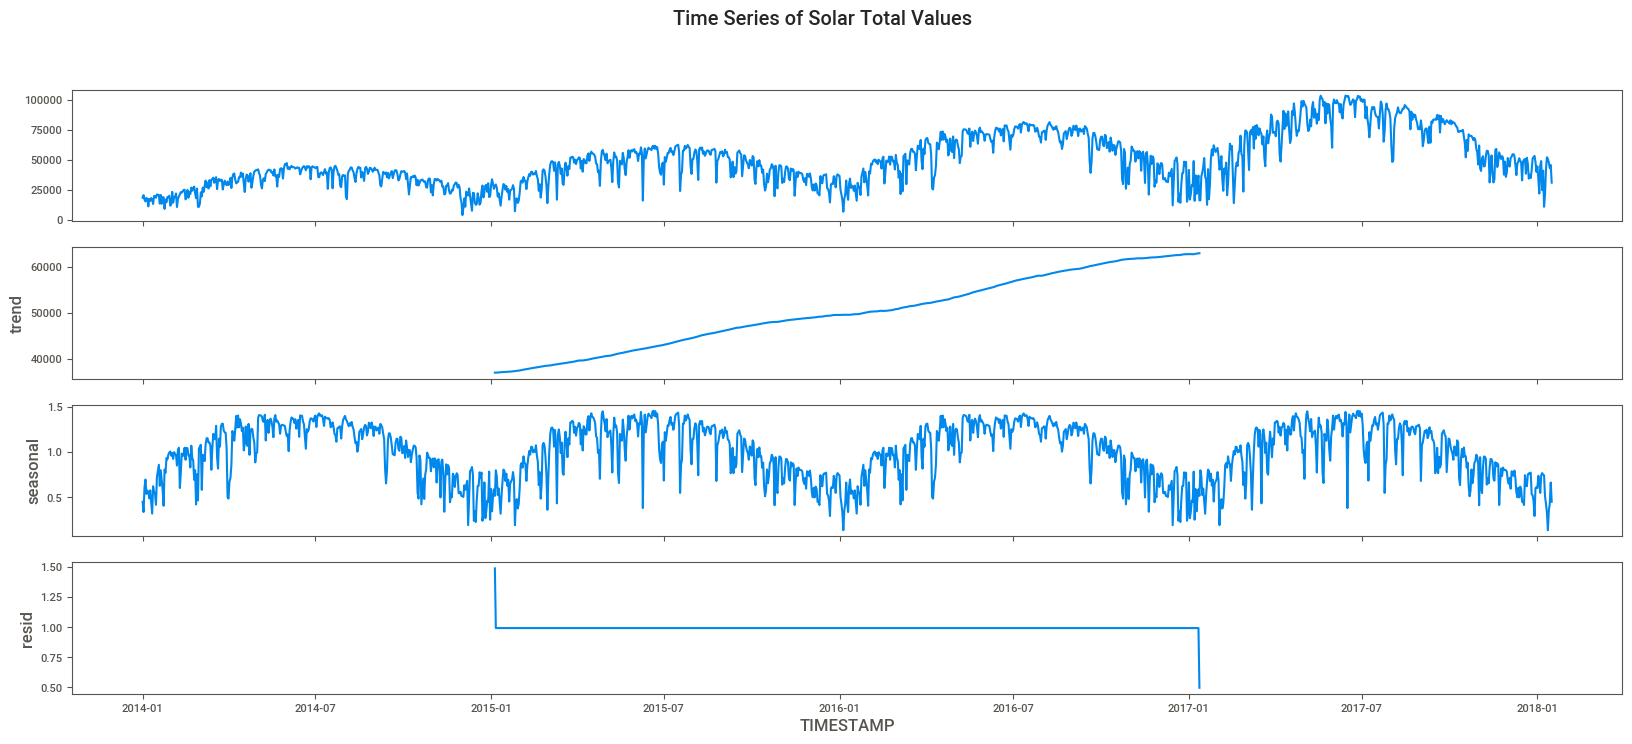

In [127]:
fig, axes = plt.subplots(4, 1, figsize=(20,8), sharex=True)
fig.suptitle('Time Series of Solar Total Values')

sns.lineplot(x=obs.index, y=obs, ax=axes[0], data=obs)
sns.lineplot(x=trend.index, y=trend, ax=axes[1], data=trend)
sns.lineplot(x=seazon.index, y=seazon, ax=axes[2], data=seazon)
sns.lineplot(x=random.index, y=random, ax=axes[3], data=random)

**Verificação da Estacionaridade**

In [128]:
adf = ADFTest(alpha=0.05)
adf.is_stationary(dataTimeMean)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.
  


(0.36856776594207685, True)

**Divisão das bases em treinamento e teste**

In [129]:
train = dataTimeMean.loc[dataTimeMean.index.year < 2017]
train

SOLAR TOTAL
TIMESTAMP              
2014-01-01      18326.0
2014-01-02      20441.0
2014-01-03      16721.0
2014-01-04      15228.0
2014-01-05      18207.0
...                 ...
2016-12-27      48332.0
2016-12-28      44828.0
2016-12-29      48165.0
2016-12-30      15014.0
2016-12-31      20791.0

[1096 rows x 1 columns]

In [130]:
test = dataTimeMean.loc[dataTimeMean.index.year > 2016]
test

SOLAR TOTAL
TIMESTAMP              
2017-01-01      41428.0
2017-01-02      16778.0
2017-01-03      21487.0
2017-01-04      28917.0
2017-01-05      28140.0
...                 ...
2018-01-12      50614.0
2018-01-13      47508.0
2018-01-14      42947.0
2018-01-15      45541.0
2018-01-16      30839.0

[381 rows x 1 columns]

**Visualização treino e teste**

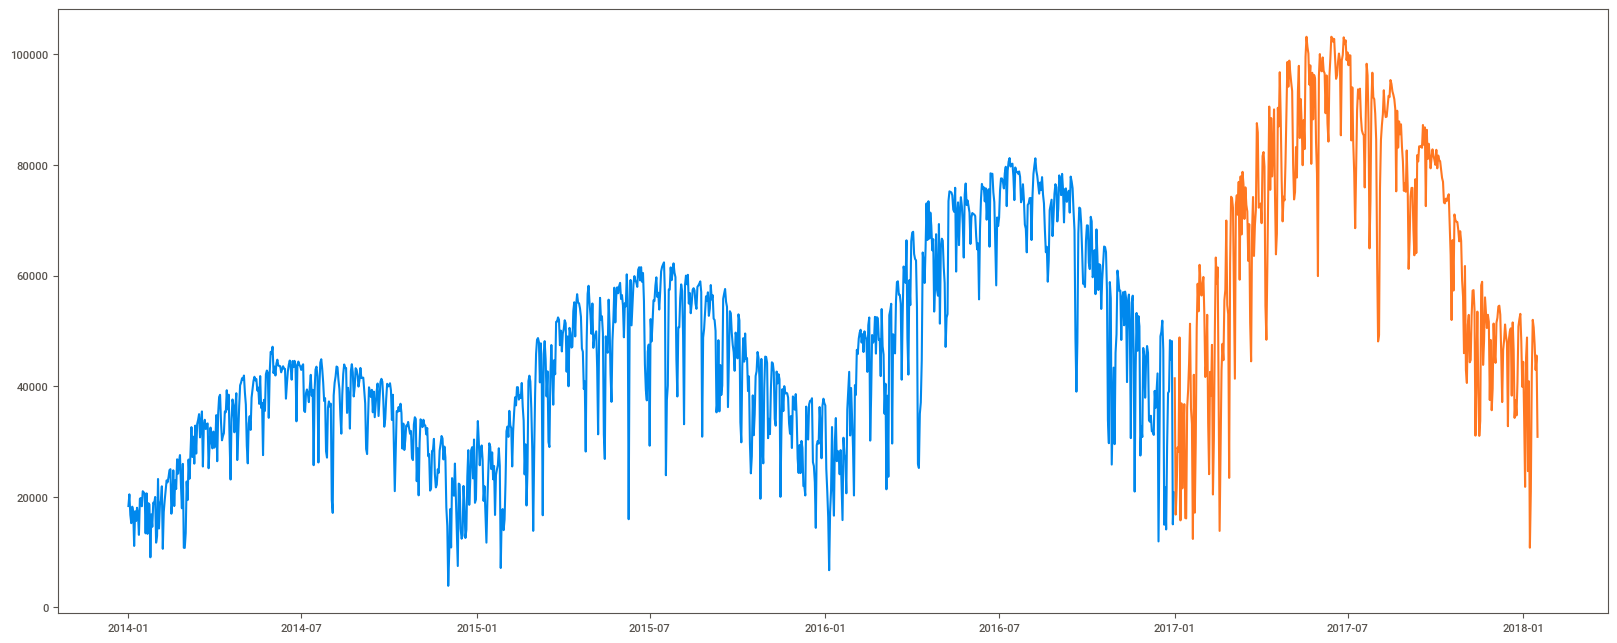

In [131]:
#train, test = model_selection.train_test_split(dataTimeMean, train_size=0.8)
train = dataTimeMean.loc[dataTimeMean.index.year < 2017]
test = dataTimeMean.loc[dataTimeMean.index.year > 2016]
fig, axes = plt.subplots(1, 1, figsize=(20,8), sharex=True)
plt.plot(train)
plt.plot(test)

###**e. Vamos criar um modelo de predição usando Prophet. Divida a série temporal SOLAR TOTAL (com freq 1D) em treino e teste (treino até 12-2016 e teste depois disso). Crie um modelo usando apenas treino e projete os valores do forecast para o mesmo período que o conjunto de treino.**

In [132]:
df_prophet = train.copy()

In [133]:
df_prophet = df_prophet.reset_index().rename(columns={'TIMESTAMP': 'ds', 'SOLAR TOTAL': 'y'})
df_prophet

ds        y
0    2014-01-01  18326.0
1    2014-01-02  20441.0
2    2014-01-03  16721.0
3    2014-01-04  15228.0
4    2014-01-05  18207.0
...         ...      ...
1091 2016-12-27  48332.0
1092 2016-12-28  44828.0
1093 2016-12-29  48165.0
1094 2016-12-30  15014.0
1095 2016-12-31  20791.0

[1096 rows x 2 columns]

In [134]:
model_prophet = Prophet(seasonality_mode='multiplicative', interval_width=0.99, seasonality_prior_scale=10)

In [135]:
model_prophet.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:401: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

In [136]:
train.shape[0]

1096

In [137]:
test.shape[0]

381

In [138]:
periods = train.shape[0]
future = model_prophet.make_future_dataframe(periods=periods, freq="1D")
forecast = model_prophet.predict(future)

/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)


In [139]:
forecast.head()

ds         trend   yhat_lower    yhat_upper   trend_lower  \
0 2014-01-01  26287.732894 -3471.485695  33882.129699  26287.732894   
1 2014-01-02  26317.058353 -3183.950686  33453.070732  26317.058353   
2 2014-01-03  26346.383812 -3590.990934  33146.984661  26346.383812   
3 2014-01-04  26375.709271 -1681.149580  34149.466277  26375.709271   
4 2014-01-05  26405.034730 -5648.848668  32924.209945  26405.034730   

    trend_upper  multiplicative_terms  multiplicative_terms_lower  \
0  26287.732894             -0.403562                   -0.403562   
1  26317.058353             -0.411593                   -0.411593   
2  26346.383812             -0.418665                   -0.418665   
3  26375.709271             -0.426238                   -0.426238   
4  26405.034730             -0.450121                   -0.450121   

   multiplicative_terms_upper    weekly  weekly_lower  weekly_upper    yearly  \
0                   -0.403562  0.007766      0.007766      0.007766 -0.411328   
1                   -0.411593  0.003236      0.003236      0.003236 -0.414829   
2                   -0.418665  0.000442      0.000442      0.000442 -0.419107   
3                   -0.426238 -0.002204     -0.002204     -0.002204 -0.424035   
4                   -0.450121 -0.020660     -0.020660     -0.020660 -0.429462   

   yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
0     -0.411328     -0.411328             0.0                   0.0   
1     -0.414829     -0.414829             0.0                   0.0   
2     -0.419107     -0.419107             0.0                   0.0   
3     -0.424035     -0.424035             0.0                   0.0   
4     -0.429462     -0.429462             0.0                   0.0   

   additive_terms_upper          yhat  
0                   0.0  15678.991360  
1                   0.0  15485.145661  
2                   0.0  15316.077552  
3                   0.0  15133.375840  
4                   0.0  14519.565787

In [140]:
forecast.tail()

ds          trend    yhat_lower    yhat_upper    trend_lower  \
2187 2019-12-28  113336.111670  49382.505434  86540.330213  106226.195130   
2188 2019-12-29  113380.290835  47230.265417  83331.470208  106258.890094   
2189 2019-12-30  113424.470001  47410.290368  88056.204318  106291.585057   
2190 2019-12-31  113468.649166  49298.519221  87688.661010  106324.280020   
2191 2020-01-01  113512.828332  50362.708818  88234.801211  106356.974984   

        trend_upper  multiplicative_terms  multiplicative_terms_lower  \
2187  120409.052116             -0.409345                   -0.409345   
2188  120458.083617             -0.427013                   -0.427013   
2189  120507.115118             -0.404295                   -0.404295   
2190  120556.146620             -0.398578                   -0.398578   
2191  120605.178121             -0.402135                   -0.402135   

      multiplicative_terms_upper    weekly  weekly_lower  weekly_upper  \
2187                   -0.409345 -0.002204     -0.002204     -0.002204   
2188                   -0.427013 -0.020660     -0.020660     -0.020660   
2189                   -0.404295  0.002256      0.002256      0.002256   
2190                   -0.398578  0.009163      0.009163      0.009163   
2191                   -0.402135  0.007766      0.007766      0.007766   

        yearly  yearly_lower  yearly_upper  additive_terms  \
2187 -0.407141     -0.407141     -0.407141             0.0   
2188 -0.406353     -0.406353     -0.406353             0.0   
2189 -0.406551     -0.406551     -0.406551             0.0   
2190 -0.407742     -0.407742     -0.407742             0.0   
2191 -0.409901     -0.409901     -0.409901             0.0   

      additive_terms_lower  additive_terms_upper          yhat  
2187                   0.0                   0.0  66942.571999  
2188                   0.0                   0.0  64965.424918  
2189                   0.0                   0.0  67567.560612  
2190                   0.0                   0.0  68242.491992  
2191                   0.0                   0.0  67865.314135

###**Visualização predição com o mesmo perído da base de treino**

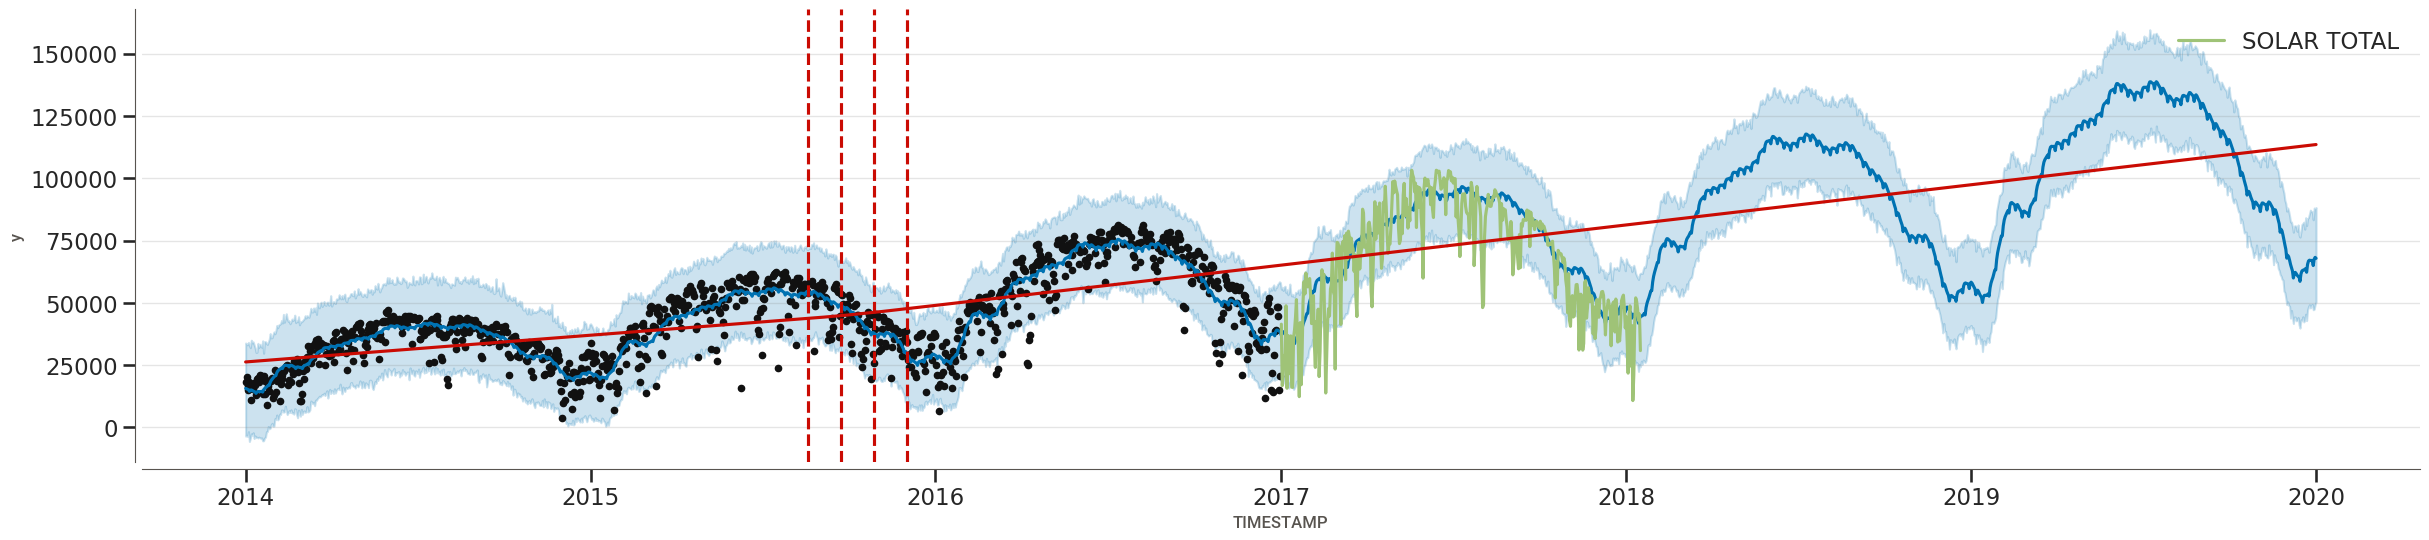

In [141]:
fig, ax= plt.subplots(1, 1, figsize=(24, 6))
sns.set_style("ticks")

sns.set_context("talk")
model_prophet.plot(forecast, ax=ax);

test.plot(ax=ax, c="g");
ax.yaxis.grid(True)
add_changepoints_to_plot(fig.gca(), model_prophet, forecast)
sns.despine(offset=5, trim=False)

/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)


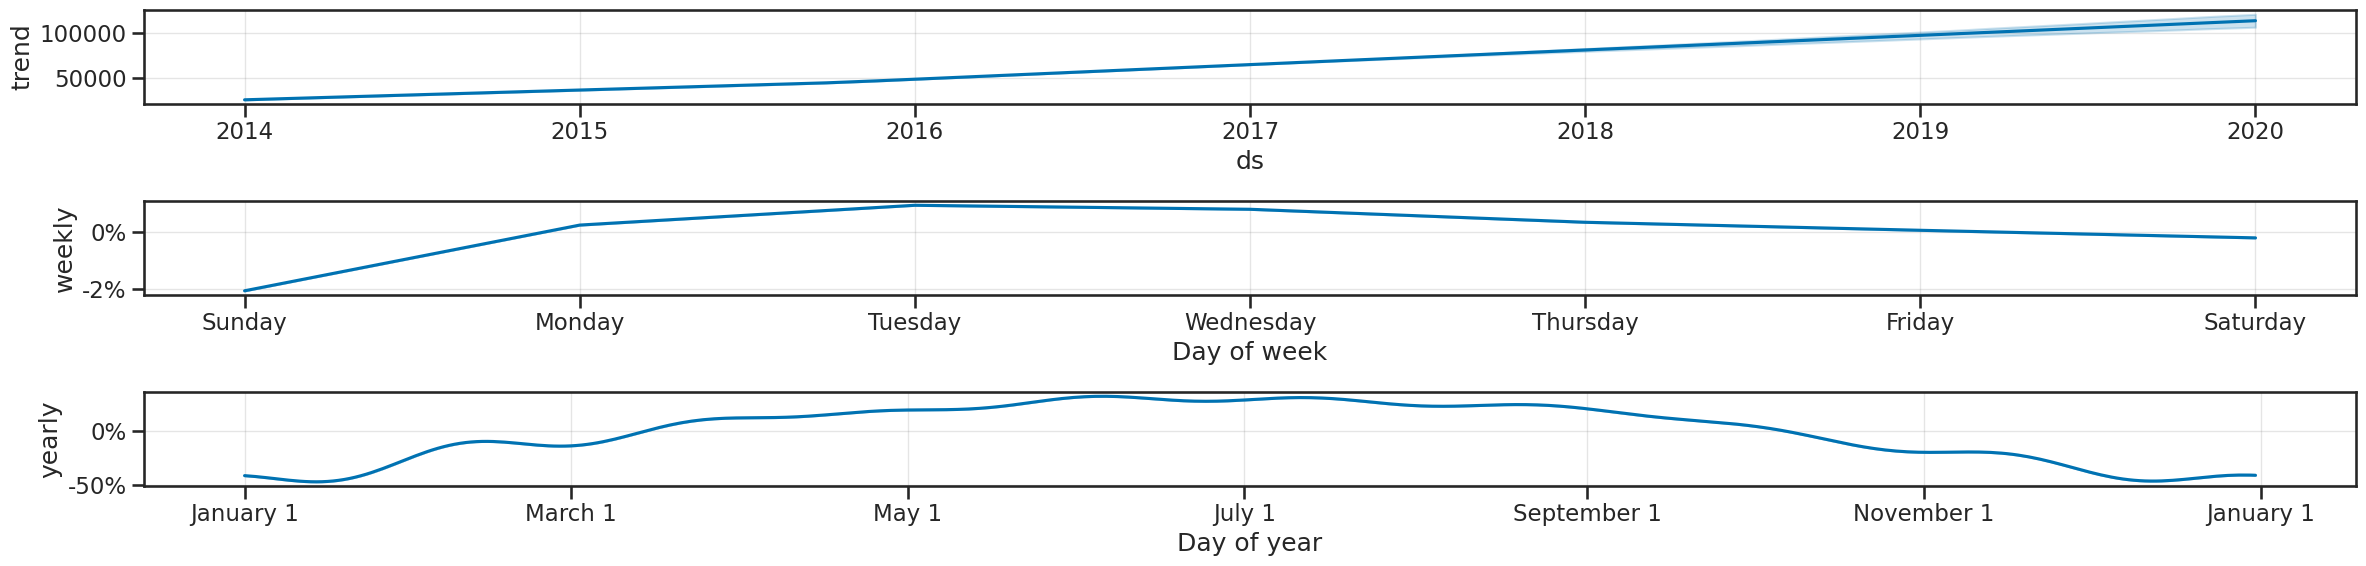

In [142]:
fig = model_prophet.plot_components(forecast, figsize=(24,6))

In [143]:
df_cv = cross_validation(model_prophet, horizon='30 days', period='10 days', initial='1 days', parallel='processes')

INFO:fbprophet:Making 107 forecasts with cutoffs between 2014-01-06 00:00:00 and 2016-12-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa18f258550>
/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:401: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When

###**f. Calcule o R2 Score e Mean Average Error entre a previsão e o conjunto de testes.**

In [144]:
df_p = performance_metrics(df_cv)
df_p.head(10)

horizon           mse           rmse           mae      mape     mdape  \
0  3 days  1.018004e+08   10089.616011   7005.584538  0.220219  0.111978   
1  4 days  1.547356e+08   12439.275211   7919.341247  0.256504  0.118535   
2  5 days  2.495108e+08   15795.911891   9050.825468  0.312253  0.122710   
3  6 days  4.346284e+08   20847.744380  10397.214967  0.354735  0.128409   
4  7 days  7.539042e+08   27457.315618  11867.803741  0.413061  0.131629   
5  8 days  1.351210e+09   36758.802214  13681.296154  0.480308  0.134070   
6  9 days  2.329097e+09   48260.723149  16182.100491  0.602477  0.136299   
7 10 days  3.955965e+09   62896.461828  19009.343440  0.742117  0.141962   
8 11 days  6.427766e+09   80173.347640  22645.741242  0.967327  0.149839   
9 12 days  1.024618e+10  101223.409295  26646.090937  1.107121  0.145072   

   coverage  
0  0.875389  
1  0.850467  
2  0.819315  
3  0.803738  
4  0.791277  
5  0.791277  
6  0.769470  
7  0.775701  
8  0.781931  
9  0.791277

/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


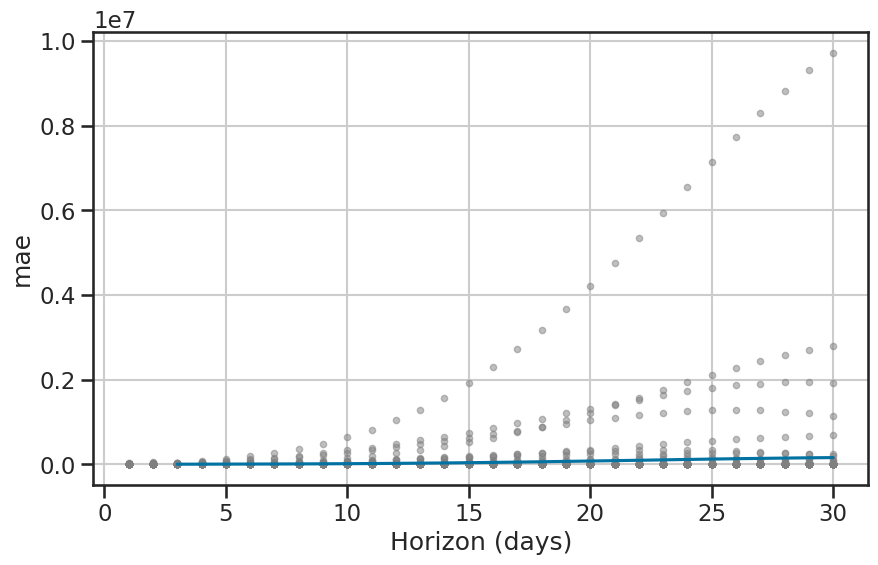

In [145]:
fig = plot_cross_validation_metric(df_cv, metric='mae')
plt.show()

In [146]:
forecast_filtered = forecast.loc[(forecast.index > 1095) & (forecast.index <= 1476)]

In [147]:
y_pred = forecast_filtered.yhat

In [148]:
print("R^2 Score(coefficient of determination) = "+str(r2_score(test, y_pred).round(2)))

R^2 Score(coefficient of determination) = 0.71
